In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('penguins_train.csv')
test_data = pd.read_csv('penguins_test.csv')
train_data.shape

(274, 10)

In [3]:
train_data.head()

,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Species
0,Biscoe,Yes,38.8,17.2,180.0,3800.0,MALE,9.63954,-25.29856,Adelie Penguin (Pygoscelis adeliae)
1,Torgersen,Yes,41.1,18.6,189.0,3325.0,MALE,9.32277,-26.09989,Adelie Penguin (Pygoscelis adeliae)
2,Biscoe,Yes,39.0,17.5,186.0,3550.0,FEMALE,8.57199,-26.07188,Adelie Penguin (Pygoscelis adeliae)
3,Dream,No,39.7,17.9,193.0,4250.0,MALE,9.25769,-25.88798,Adelie Penguin (Pygoscelis adeliae)
4,Biscoe,Yes,47.5,14.2,209.0,4600.0,FEMALE,8.39299,-26.78733,Gentoo penguin (Pygoscelis papua)


<AxesSubplot:>

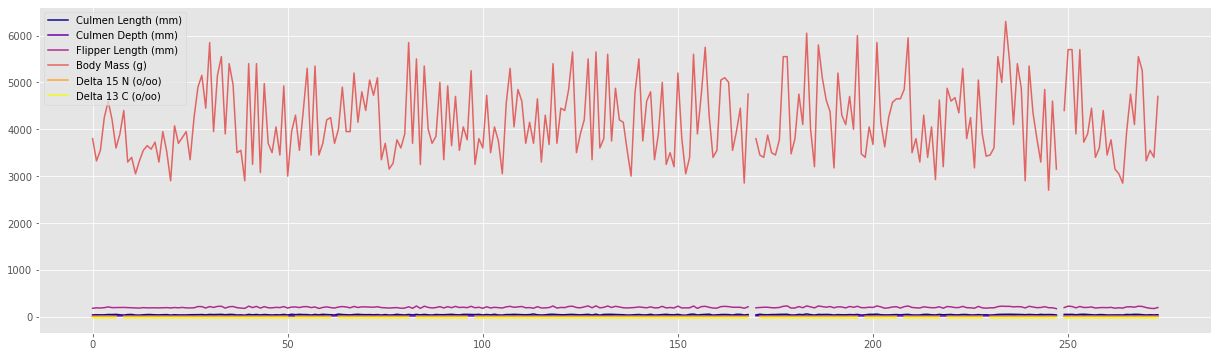

In [4]:
plt.style.use('ggplot')

train_data.plot(figsize=(21,6),colormap='plasma')

From above we can see that there are some missing data in the features. We will compensate the missing data without removing the corresponding tuple by imputing them

#### Handling missing data 

In [5]:
from sklearn.impute import SimpleImputer

<AxesSubplot:>

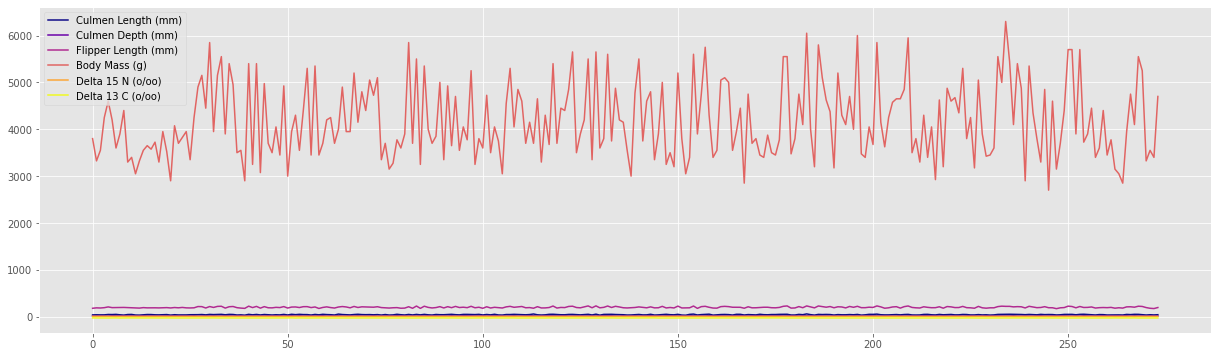

In [6]:
imputer = SimpleImputer(strategy='most_frequent')
train_imputer = imputer.fit_transform(train_data.copy())
tr_data = pd.DataFrame(train_imputer, columns=list(train_data.columns))
test_imputer = imputer.fit_transform(test_data.copy())
ts_data = pd.DataFrame(test_imputer, columns=list(test_data.columns))
tr_data.plot(figsize=(21,6), colormap='plasma')

In [7]:
features = list(tr_data.drop('Species', axis=1).columns)
features

['Island',
 'Clutch Completion',
 'Culmen Length (mm)',
 'Culmen Depth (mm)',
 'Flipper Length (mm)',
 'Body Mass (g)',
 'Sex',
 'Delta 15 N (o/oo)',
 'Delta 13 C (o/oo)']

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [9]:
df = tr_data.copy()
string_columns = df[['Island','Clutch Completion', 'Sex', 'Species']]
encoded_data = {c:LabelEncoder() for c in string_columns}
for cols, attributes in encoded_data.items():
    df[cols] = encoded_data[cols].fit_transform(df[cols])

df.head()

,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Species
0,0,1,38.8,17.2,180.0,3800.0,2,9.63954,-25.29856,0
1,2,1,41.1,18.6,189.0,3325.0,2,9.32277,-26.09989,0
2,0,1,39.0,17.5,186.0,3550.0,1,8.57199,-26.07188,0
3,1,0,39.7,17.9,193.0,4250.0,2,9.25769,-25.88798,0
4,0,1,47.5,14.2,209.0,4600.0,1,8.39299,-26.78733,2


In [11]:
X = df[features]
y = df['Species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
n_estimators = 100
criterion = 'entropy'
max_depth = 10
min_samples_split = 4


classifier = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)

classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)
prob_pred = classifier.predict_proba(X_test)


RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [13]:
predictions

array([2, 0, 0, 0, 0, 2, 2, 0, 2, 1, 1, 1, 0, 2, 2, 1, 0, 0, 1, 2, 0, 0,
       0, 0, 1, 0, 1, 2, 1, 2, 0, 2, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 0, 2,
       2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2])

In [14]:
metrics.accuracy_score(predictions, y_test)

0.9818181818181818

In [15]:
encoded_data['Species'].inverse_transform(predictions).shape[0]

55

In [16]:
encoded_data

{'Island': LabelEncoder(),
 'Clutch Completion': LabelEncoder(),
 'Sex': LabelEncoder(),
 'Species': LabelEncoder()}

#### Splitting training and testing data compatible with my original classifier

In [17]:
X_train = df[features][:int(0.8*df.shape[0])]
y_train = df['Species'][:int(0.8*df.shape[0])]


In [18]:
X_test = df[features][int(0.8*df.shape[0]):]
y_test = df['Species'][int(0.8*df.shape[0]):]

In [19]:
def create_trees(X_train, Y_train, max_depth, min_size, n_features, criterion):

    D1 = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split = min_size, max_features=n_features)
    D1.fit(X_train, Y_train)
    return D1

In [20]:
import random

def Random_forest(X_train, Y_train, X_test, criterion, max_depth, min_size, estimators, min_features):
  
  # Initialising parameters to be selected randomly for tree formation
  max_depth_list = list(range(2,max_depth))
  criterion_list = ["gini", "entropy"]
  min_size_list = list(range(3,min_size))
  n_features_list = list(range(min_features ,X_train.shape[1]))
  max_rows = X_train.shape[0]

  all_preds = []

  for i in tqdm(range(estimators)):     # creating 'n' decision trees | n = estimators
    ids = np.random.randint(max_rows, size=(int(.8*max_rows)))
    X_train_split = []
    Y_train_split = []
    for x in ids:     # Bootstrapping to compensate for less data
      row = X_train.sample()
      X_train_split.append(list(row.values[0]))
      Y_train_split.append(y_train.iloc[row.index[0]])

    X_train_split = np.array(X_train_split)
    Y_train_split = np.array(Y_train_split)

    # Choosing the random parameters 
    id_max_depth = np.random.randint(len(max_depth_list),size=1)[0]
    id_criterion = np.random.randint(len(criterion_list),size=1)[0]
    id_min_size = np.random.randint(len(min_size_list),size=1)[0]
    id_feature = np.random.randint(len(n_features_list),size=1)[0]

    tree = create_trees(X_train_split, Y_train_split, max_depth_list[id_max_depth], min_size_list[id_min_size],
                        n_features_list[id_feature], criterion = criterion_list[id_criterion])
    pred = tree.predict(X_test)
    all_preds.append(pred)    # Adding all prediction to an array

  all_preds = np.array(all_preds)

  Y_pred = []     # Initialising final prediction labels
  Y_prob = []     # Initialising class prediction probability  
  for i in range(all_preds.shape[1]):
    temp = all_preds[:,i]
    counts = np.bincount(temp)
    
    # Storing class probability of prediction
    if len(counts) == 1:
      cnt = [counts[0]/estimators, 0, 0]
      Y_prob.append(cnt)
    elif len(counts) == 2:
      cnt = [counts[0]/estimators, counts[1]/estimators, 0]
      Y_prob.append(cnt)
    else:
      Y_prob.append([counts[0]/estimators, counts[1]/estimators, counts[2]/estimators]) 
    
    Y_pred.append(np.argmax(counts))    # Storing the most voted prediction

  Y_pred = np.array(Y_pred)
  Y_prob = np.array(Y_prob)

  return Y_pred, Y_prob
#print(all_preds.shape)
#print(Y_pred.shape)

In [21]:
Y_pred, Y_prob = Random_forest(X_train, y_train, X_test,criterion="entropy", max_depth=8, min_size=4,
                        estimators=150, min_features=4)

  0%|          | 0/150 [00:00<?, ?it/s]

In [22]:
lst = []
a = [1, 2, 3]
b = [2, 4, 3]
lst.append(a)
lst.append(b)
lst

[[1, 2, 3], [2, 4, 3]]

In [23]:
Y_pred

array([2, 2, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 0, 2,
       2, 0, 1, 2, 1, 0, 0, 0, 1, 2, 2, 0, 2, 1, 1, 2, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 2, 1, 2, 2, 0, 0, 0, 0], dtype=int64)

In [24]:
Y_prob

array([[0.00666667, 0.        , 0.99333333],
       [0.00666667, 0.        , 0.99333333],
       [0.78666667, 0.2       , 0.01333333],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.01333333, 0.98666667, 0.        ],
       [0.98666667, 0.01333333, 0.        ],
       [0.99333333, 0.00666667, 0.        ],
       [0.        , 0.        , 1.        ],
       [0.98666667, 0.01333333, 0.        ],
       [0.94      , 0.        , 0.06      ],
       [0.97333333, 0.        , 0.02666667],
       [1.        , 0.        , 0.        ],
       [0.        , 0.00666667, 0.99333333],
       [0.        , 0.        , 1.        ],
       [0.01333333, 0.14      , 0.84666667],
       [0.        , 0.        , 1.        ],
       [0.14666667, 0.82      , 0.03333333],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.58      , 0.38      , 0.04      ],
       [0.        , 0.        , 1.        ],
       [0.

In [25]:
metrics.accuracy_score(Y_pred, y_test)

0.9636363636363636

In [26]:
predictions = encoded_data['Species'].inverse_transform(Y_pred)

#pd.DataFrame(data=predictions, columns=['predictions']).to_csv('pred.csv')
predictions

array(['Gentoo penguin (Pygoscelis papua)',
       'Gentoo penguin (Pygoscelis papua)',
       'Adelie Penguin (Pygoscelis adeliae)',
       'Adelie Penguin (Pygoscelis adeliae)',
       'Gentoo penguin (Pygoscelis papua)',
       'Chinstrap penguin (Pygoscelis antarctica)',
       'Adelie Penguin (Pygoscelis adeliae)',
       'Adelie Penguin (Pygoscelis adeliae)',
       'Gentoo penguin (Pygoscelis papua)',
       'Adelie Penguin (Pygoscelis adeliae)',
       'Adelie Penguin (Pygoscelis adeliae)',
       'Adelie Penguin (Pygoscelis adeliae)',
       'Adelie Penguin (Pygoscelis adeliae)',
       'Gentoo penguin (Pygoscelis papua)',
       'Gentoo penguin (Pygoscelis papua)',
       'Gentoo penguin (Pygoscelis papua)',
       'Gentoo penguin (Pygoscelis papua)',
       'Chinstrap penguin (Pygoscelis antarctica)',
       'Gentoo penguin (Pygoscelis papua)',
       'Gentoo penguin (Pygoscelis papua)',
       'Adelie Penguin (Pygoscelis adeliae)',
       'Gentoo penguin (Pygoscelis papua)'

### 2. Experiment with various classifiers such as KNN, Decision Trees, Random Forests etc. Which classifier performs the best?(10)


- Naive Bayes
- Decision Trees
- SVM
- KNN

#### Naive Bayes

In [27]:
from sklearn.naive_bayes import GaussianNB
naive = GaussianNB()
naive.fit(X_train, y_train)
naive_prediction = naive.predict(X_test)
print(f"Naive Prediction:\n{naive_prediction}\n")
print(f"accuracy = {metrics.accuracy_score(naive_prediction, y_test)}")

Naive Prediction:
[2 2 0 0 2 1 0 0 2 0 0 0 0 2 2 2 2 1 2 2 1 2 2 0 1 2 1 0 0 0 1 2 2 0 2 1 1
 2 0 1 1 0 0 0 0 0 1 2 1 2 2 0 0 0 0]

accuracy = 0.9818181818181818


#### Decision Trees

In [28]:
decision = DecisionTreeClassifier(criterion='entropy',splitter='best')
decision.fit(X_train, y_train)
decision_prediction = decision.predict(X_test)
print(f"Decision Tree Prediction:\n{decision_prediction}\n")
print(f"accuracy = {metrics.accuracy_score(decision_prediction, y_test)}")

Decision Tree Prediction:
[2 2 0 0 2 1 0 0 2 0 0 0 0 2 2 2 2 1 2 2 0 2 2 0 1 2 1 0 0 0 1 2 2 0 2 1 0
 2 0 1 1 0 0 0 0 0 1 2 1 2 2 0 0 0 0]

accuracy = 0.9454545454545454


#### SVM

In [29]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
svm_prediction = svm.predict(X_test)
print(f"SVM Prediction:\n{svm_prediction}\n")
print(f"accuracy = {metrics.accuracy_score(svm_prediction, y_test)}")

SVM Prediction:
[2 2 2 0 2 0 0 0 2 0 0 0 0 2 2 2 2 0 2 2 0 2 0 0 0 2 0 2 0 0 0 2 2 0 2 0 0
 2 0 0 0 0 0 0 0 0 0 2 0 2 2 0 0 0 2]

accuracy = 0.7272727272727273


#### KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier

k = 5
knn = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='brute')
knn.fit(X_train, y_train)
knn_prediction = knn.predict(X_test)
print(f"KNN Prediction:\n{knn_prediction}\n")
print(f"accuracy = {metrics.accuracy_score(knn_prediction, y_test)}")

KNN Prediction:
[2 2 2 0 2 0 0 0 2 0 0 0 0 2 2 2 2 0 2 2 0 2 2 0 0 2 0 2 0 0 0 2 2 0 2 1 0
 0 0 1 0 0 1 0 0 0 1 2 0 2 2 0 0 0 2]

accuracy = 0.7636363636363637


### 6. Plot these three error metrics specific to multi-class classification: confusion matrix, F1 score, and ROC AUC score. Which is the best error metric for this dataset and why?(20)


In [31]:
encoded_data['Species'].inverse_transform([0, 1, 2])

array(['Adelie Penguin (Pygoscelis adeliae)',
       'Chinstrap penguin (Pygoscelis antarctica)',
       'Gentoo penguin (Pygoscelis papua)'], dtype=object)

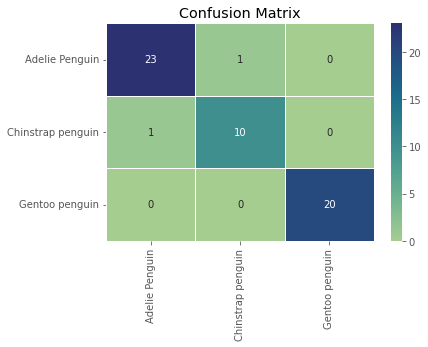

In [51]:
import seaborn as sns 

plt.style.use('ggplot')

sns.heatmap(metrics.confusion_matrix(y_test, Y_pred), annot=True, cmap='crest', linewidths=0.5)
plt.xticks([0.5, 1.5, 2.5], labels=['Adelie Penguin',
       'Chinstrap penguin',
       'Gentoo penguin'], rotation='90')
plt.yticks([0.5, 1.5, 2.5], labels=['Adelie Penguin',
       'Chinstrap penguin',
       'Gentoo penguin'], rotation='0')
plt.title('Confusion Matrix')
plt.show()

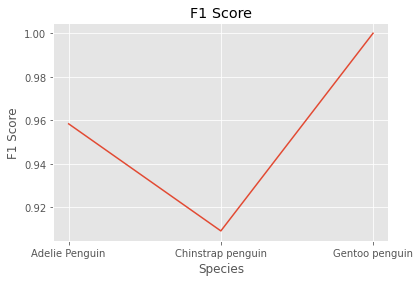

In [53]:
plt.style.use('ggplot')
plt.plot([1, 2, 3], metrics.f1_score(y_test, Y_pred, average=None))
plt.xticks([1, 2, 3], labels=['Adelie Penguin',
       'Chinstrap penguin',
       'Gentoo penguin'])
plt.xlabel('Species')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.show()

In [34]:
from sklearn.metrics import classification_report

report = classification_report(y_test, Y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        24
           1       0.91      0.91      0.91        11
           2       1.00      1.00      1.00        20

    accuracy                           0.96        55
   macro avg       0.96      0.96      0.96        55
weighted avg       0.96      0.96      0.96        55



In [35]:
CM = metrics.confusion_matrix(y_test, Y_pred)

FP = CM.sum(axis=0) - np.diag(CM)  
FN = CM.sum(axis=1) - np.diag(CM)
TP = np.diag(CM)
TN = CM.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [36]:
prob_pred[2]

array([1., 0., 0.])

In [37]:
metrics.roc_auc_score(y_test, Y_prob, multi_class='ovr', average=None)

array([0.99327957, 0.99173554, 1.        ])

In [38]:
y_t = y_test.copy()
y_t.reset_index(drop=True, inplace=True)

In [39]:
y_score = [Y_prob[i][0] for i in range(Y_prob.shape[0])]

In [40]:
dummy = y_test.copy()
dummy = dummy

In [41]:
from sklearn.preprocessing import label_binarize

dummy = label_binarize(dummy, classes=[0, 1, 2])

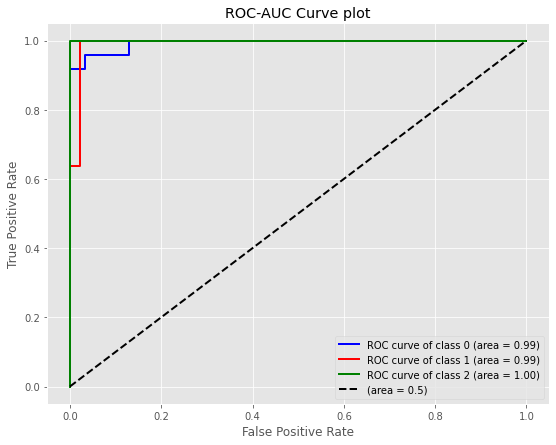

In [52]:
# ref: sklearn documentation

n_classes = 3

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(dummy[:, i], Y_prob[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green']

plt.style.use('ggplot')
plt.figure(figsize=(9,7))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw, label='(area = 0.5)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve plot')
plt.legend(loc="lower right")
plt.show()

In [ ]:
ACC

array([0.96363636, 0.96363636, 1.        ])